# LH Call UMAP
- project all calls that contain an LH segment using UMAP to determine whether there is further separation of calls

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir, FIGURE_DIR
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig

In [4]:
from scipy.stats import kruskal
from sklearn.metrics import silhouette_score, silhouette_samples

In [5]:
DATASET_ID = "git_repos_call"

In [6]:
DT_ID = '2022-03-12_17-46-00'

In [7]:
call_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'call_umap_grouped.pickle')
call_df[:3]

,start_time,end_time,labels,indv,indvi,filename,group,location,sex,wav_loc,...,comb_labels,umap,spectrogram,call_lab_simp,combi_lab_simp,call_unique_num,call_pos_combi,combi_label,combi_unique_num,simp
ID,,,,,,,,,,,,,,,,,,,,,
0,0.753604,0.921160,DSSHDS,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,...,DSSHDS,"[5.7770762, 7.997407]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS-SH-DS,DS-SH-DS SH-LH,0,0,DSSHDS SHSHLH,0,Other Calls
1,0.932017,1.367130,SHSHLH,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,...,SHSHLH,"[1.8122675, 5.094298]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",SH-LH,DS-SH-DS SH-LH,1,1,DSSHDS SHSHLH,0,Contains LH Segment
2,1.218085,1.308841,DS,MGGY,0,BWY MGGY Call Combo 1 300719 AM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,...,DS,"[9.353501, 10.055656]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",DS,DS SH-LH,2,0,DS USC,1,Other Calls


In [8]:
#get rid of the column for umap all calls as this is not needed here
call_df.drop(columns=['umap'], inplace=True)

In [9]:
len(call_df)

561

## Only Calls Containing LH

In [10]:
LHcall = ["Contains LH Segment"]

In [12]:
LHcall_df = call_df[call_df["simp"].isin(LHcall)]

In [13]:
LHcall_df[:3]

,start_time,end_time,labels,indv,indvi,filename,group,location,sex,wav_loc,...,rate,comb_labels,spectrogram,call_lab_simp,combi_lab_simp,call_unique_num,call_pos_combi,combi_label,combi_unique_num,simp
ID,,,,,,,,,,,,,,,,,,,,,
1,0.932017,1.367130,SHSHLH,MGGY,0,BWY MGGY Call Combo 1 290719 PM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,...,44100,SHSHLH,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",SH-LH,DS-SH-DS SH-LH,1,1,DSSHDS SHSHLH,0,Contains LH Segment
3,1.442686,1.984961,USC,MGGY,0,BWY MGGY Call Combo 1 300719 AM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,...,44100,USC,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",SH-LH,DS SH-LH,3,1,DS USC,1,Contains LH Segment
5,1.471596,1.897371,LH,MGGY,0,BWY MGGY Discrete 1 300719 AM,BWYa,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,...,44100,LH,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",LH,DS-SH-DS LH,5,1,DSSHDS LH,2,Contains LH Segment


In [14]:
LHcall_df.call_lab_simp.unique()

array(['SH-LH', 'LH', 'LH-DS', 'SH-DS-SH-LH', 'SH-DS-LH', 'SH-LH-DS',
       'DS-SH-DS-SH-LH'], dtype=object)

In [15]:
len(LHcall_df)

203

BMYO 13


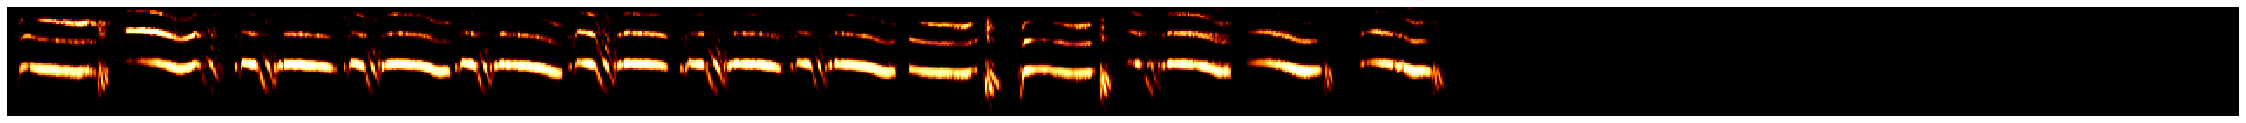

GBYM 16


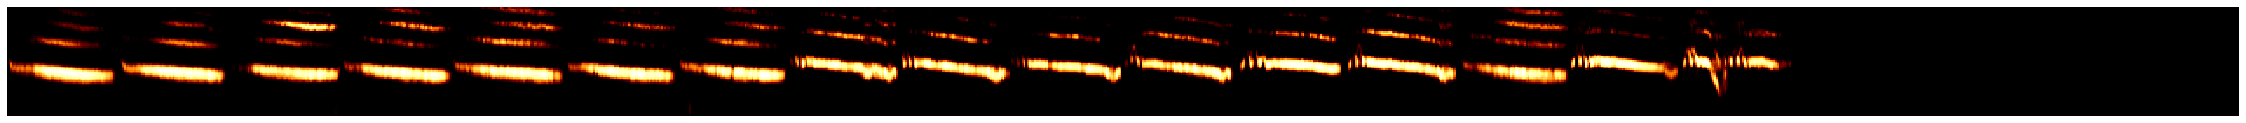

GON XF 19-21 6


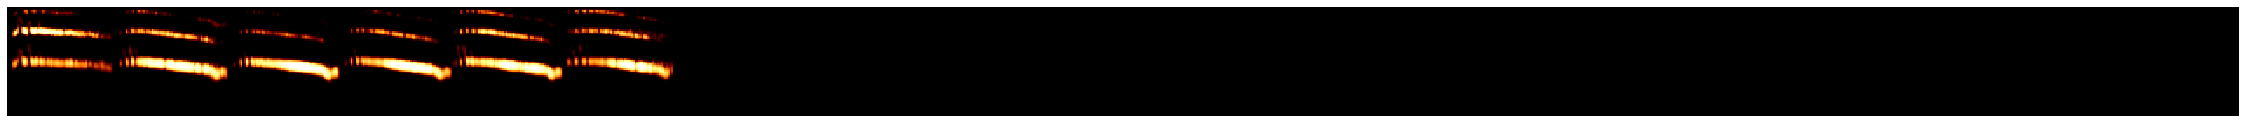

GON XM 20-21 1


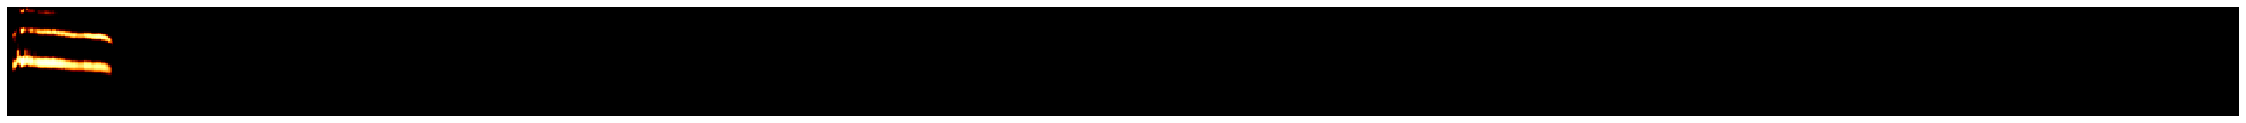

MGGY 11


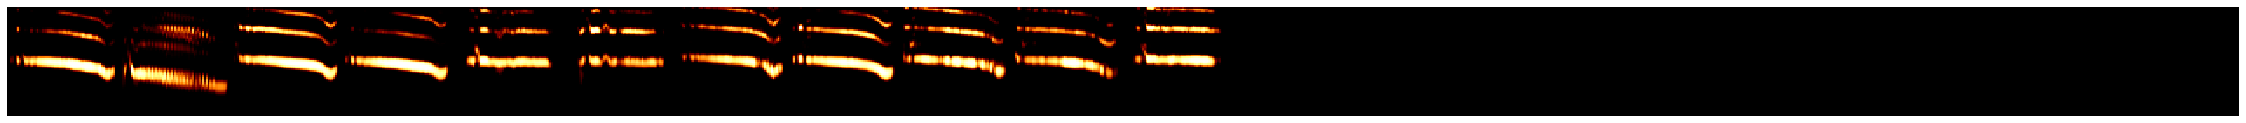

MOGO 9


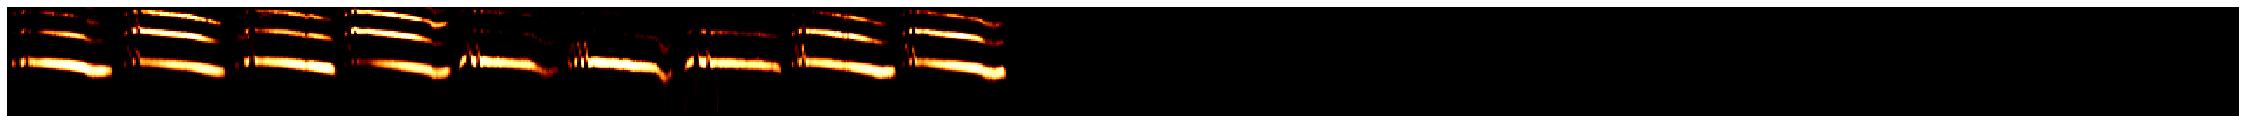

MOOO 6


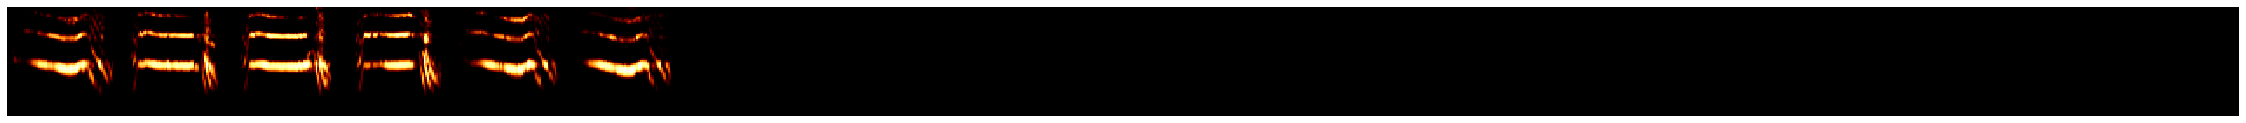

MORP 4


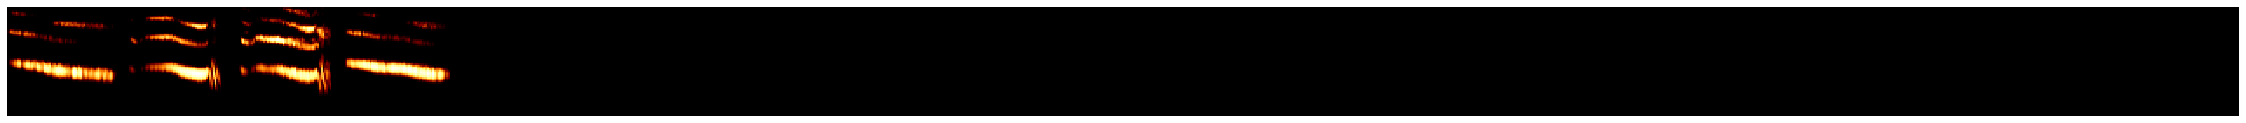

MOVY 5


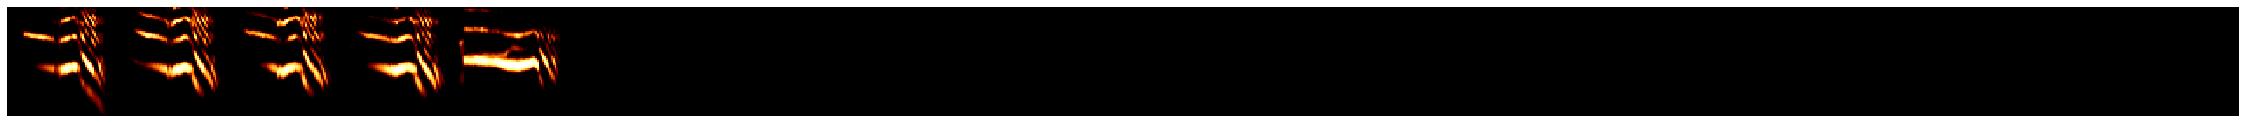

MRGO 12


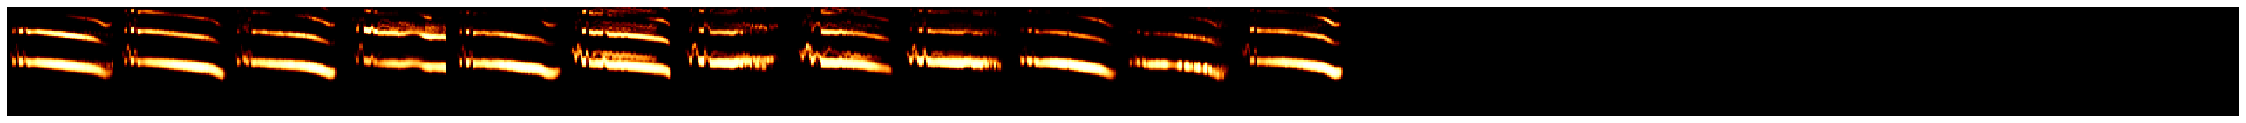

MXWW 4


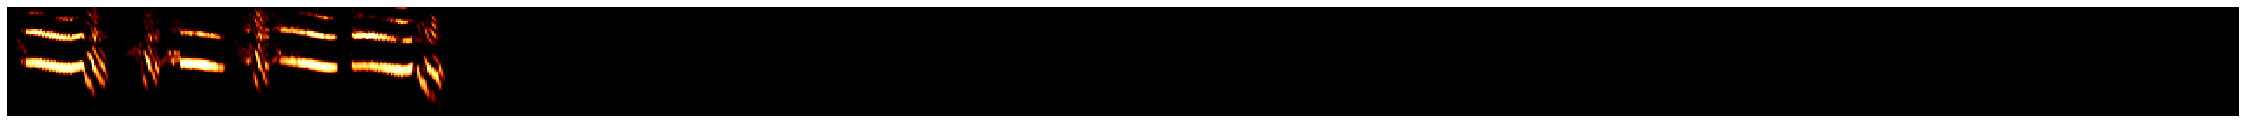

MXXGRY 18


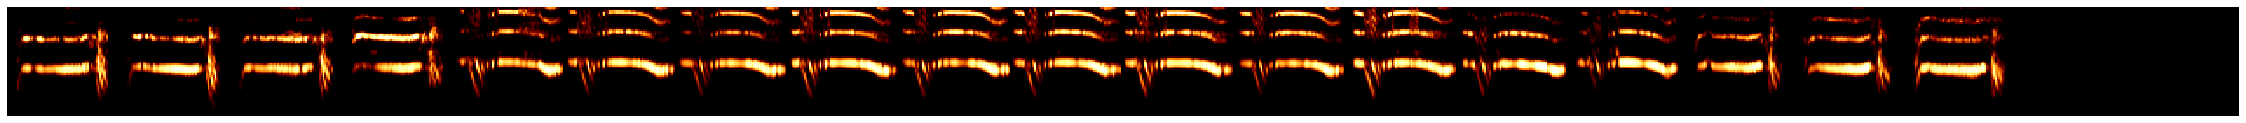

OMGO 21


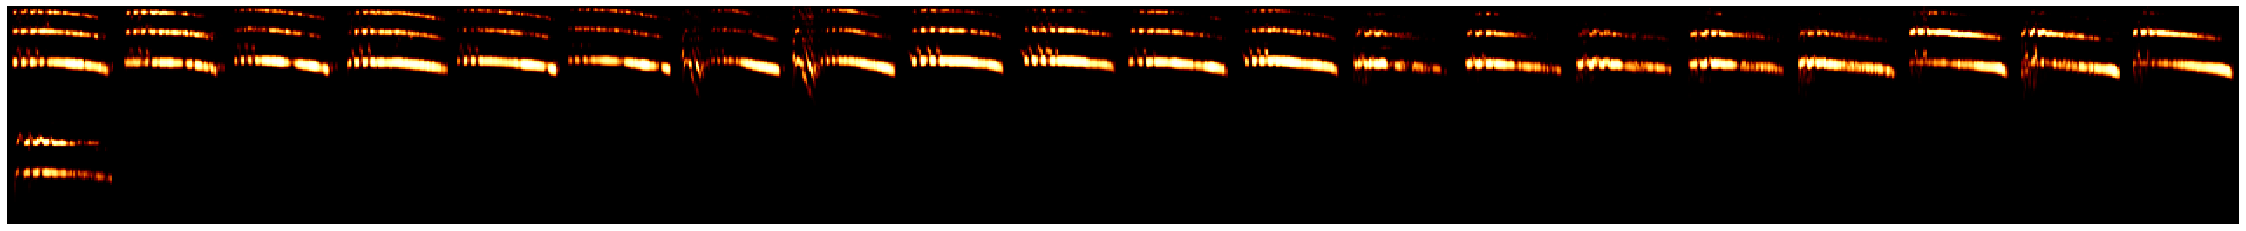

PMXRMX 3


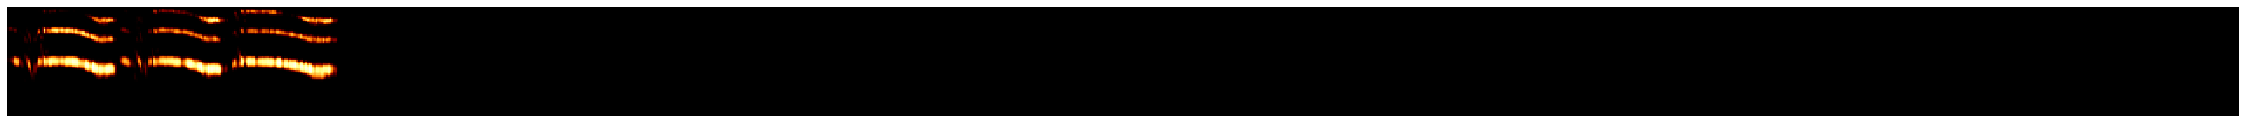

RMXGMX 11


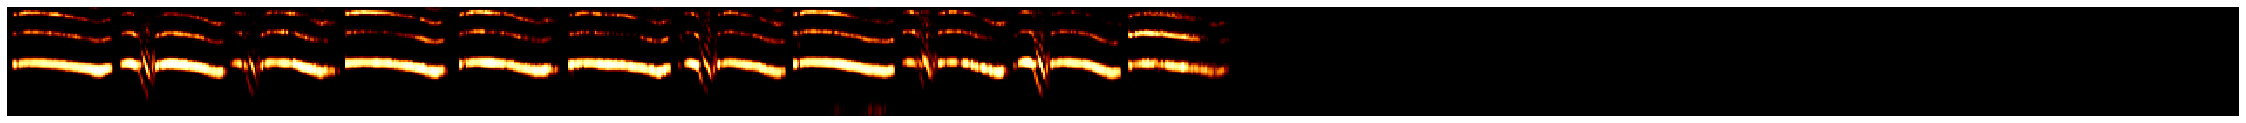

RMYG 8


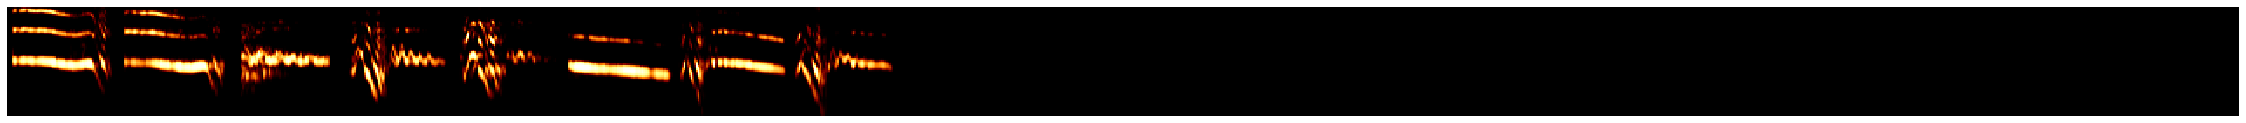

RYMR 3


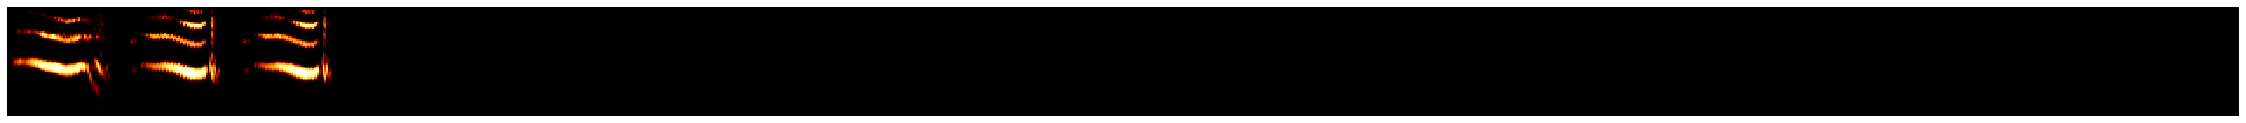

SCL XF 20-21 5


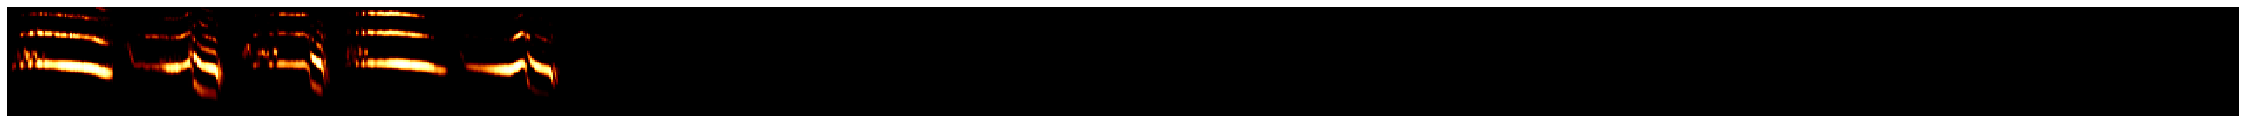

SCL XM 20-21 2


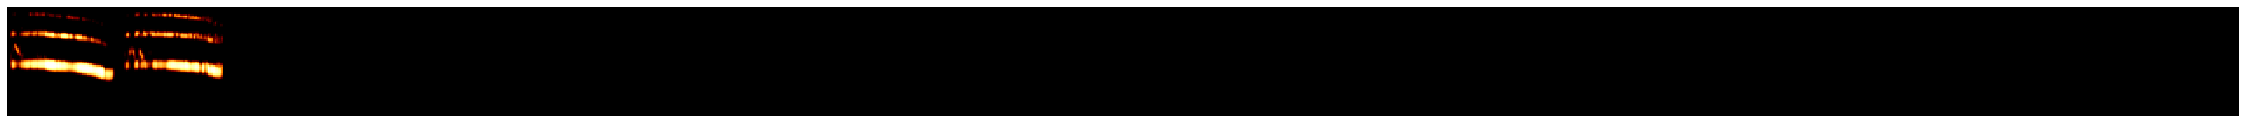

VVOM 15


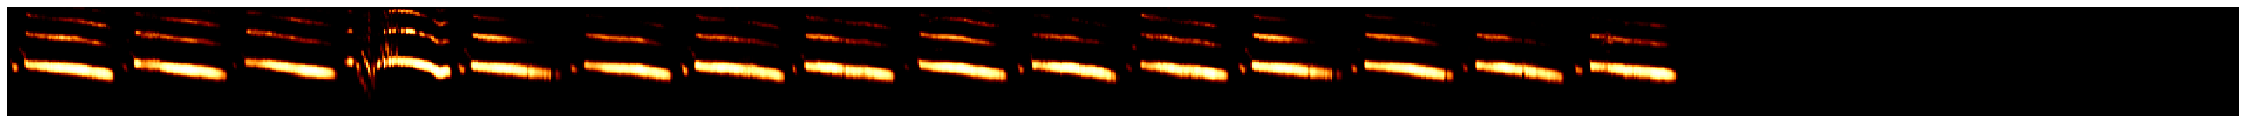

VVVM 25


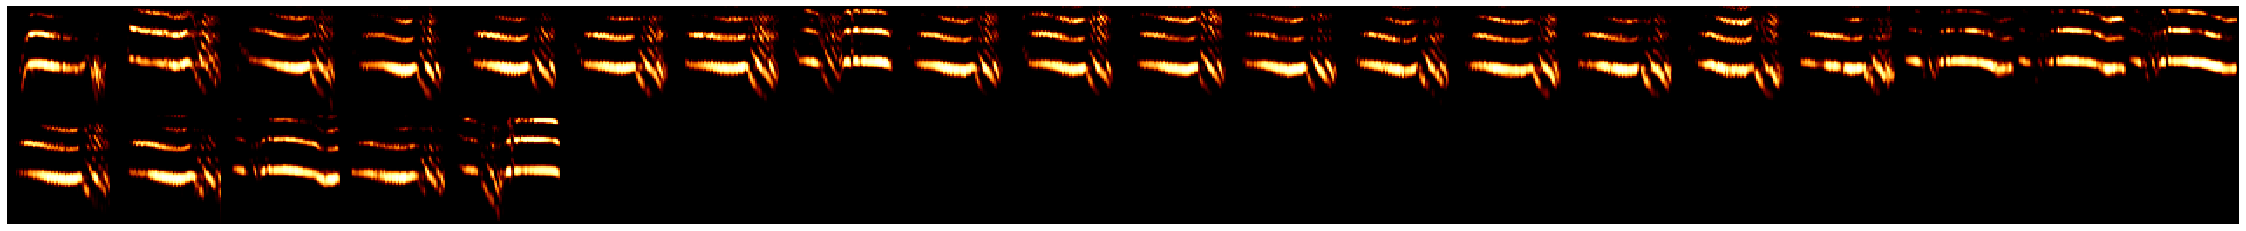

XF 20-21 5


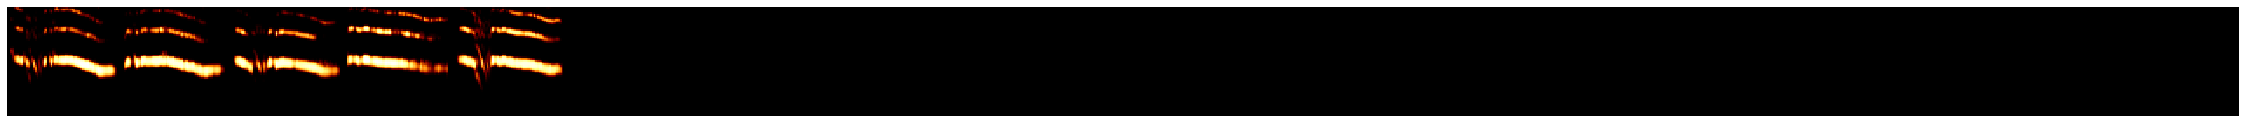

In [26]:
for indv in np.sort(LHcall_df.indv.unique()[:]):
    print(indv, np.sum(LHcall_df.indv == indv))
    specs = np.array([i/np.max(i) for i in LHcall_df[LHcall_df.indv == indv].specs.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=8, 
                  colsize=20)
    plt.show()

### Spectrograms for all individuals

In [27]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [28]:
LHcall_df = LHcall_df[np.array([np.sum(i) > 0.0 for i in LHcall_df.spectrogram.values])
]

In [29]:
specs = list(LHcall_df.spectrogram.values)
specs = [norm(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

  0%|          | 0/203 [00:00<?, ?it/s]

(203, 4096)

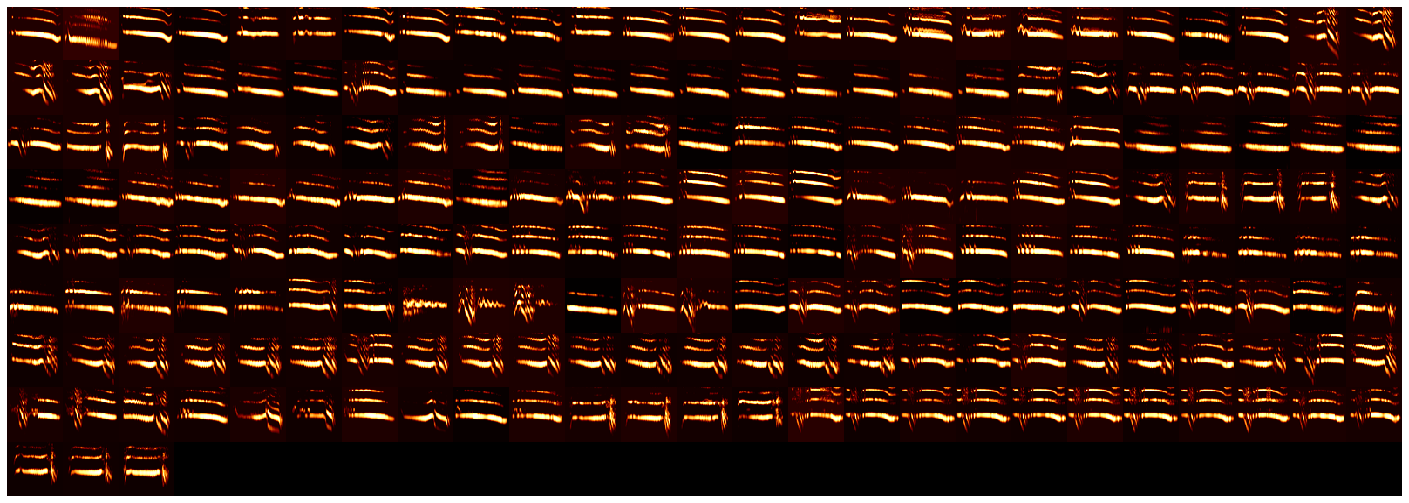

In [30]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [31]:
fit = umap.UMAP(min_dist=0.0, verbose = True)
z = list(fit.fit_transform(specs_flattened))

UMAP(min_dist=0.0, verbose=True)
Construct fuzzy simplicial set
Wed Aug 24 17:07:04 2022 Finding Nearest Neighbors
Wed Aug 24 17:07:05 2022 Finished Nearest Neighbor Search
Wed Aug 24 17:07:07 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Aug 24 17:07:09 2022 Finished embedding


In [32]:
#save df
save_loc = DATA_DIR / DATASET_ID / "LHcall" /  'LHcall_UMAP.pickle'
ensure_dir(save_loc.as_posix())
LHcall_df.to_pickle(save_loc)